In [1]:
import json
from tqdm.notebook import tqdm
import psycopg2
import psycopg2.extras
from pprint import pprint
import datetime
from numpy import interp
from matplotlib import pyplot
import pandas as pd
import pandas.io.sql as sqlio
from pandas.plotting import scatter_matrix
from matplotlib.pyplot import figure
import copy
import matplotlib.pyplot as plt
import collections

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import export_graphviz

In [3]:
def resultsAsDictArray(results, colnames):
    return_array = []
    for result in tqdm(results):
        d = {}
        for col in colnames:
            d[col] = result[colnames.index(col)]
        return_array.append(d)
    return return_array

In [4]:
conn = psycopg2.connect(user='postgres', database="postgres", password='password', host='localhost', port='5432')
cursor = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

In [5]:
cursor.execute('SELECT * FROM music')
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
musics = resultsAsDictArray(results, colnames)

  0%|          | 0/697510 [00:00<?, ?it/s]

In [6]:
cursor.execute('SELECT * FROM music_artist')
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
musics_artists_raw = resultsAsDictArray(results, colnames)

  0%|          | 0/1127195 [00:00<?, ?it/s]

In [7]:
musics_artists = {}
for music_artist in musics_artists_raw:
    music_id = music_artist['music_id']
    if music_id not in musics_artists:
        musics_artists[music_id] = []
    musics_artists[music_id].append(music_artist['artist_id'])

In [8]:
cursor.execute("""
SELECT * 
FROM artist a 
INNER JOIN genre_artist ga ON a.artist_id = ga.artist_id
INNER JOIN genre g ON g.genre_id = ga.genre_id
INNER JOIN genre_category gc ON gc.genre_id = g.genre_id
INNER JOIN category c ON c.category_id = gc.category_id
""")
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
artists_raw = resultsAsDictArray(results, colnames)

  0%|          | 0/12574 [00:00<?, ?it/s]

In [9]:
artists_multiple = {}
for artist in artists_raw:
    artist_id = artist['artist_id']
    if artist_id not in artists_multiple:
        artists_multiple[artist_id] = []
    artists_multiple[artist_id].append(artist)
#     pprint(artist)
#     break

In [10]:
artists = {}
for artist in tqdm(artists_multiple):
    for i in artists_multiple[artist]:
        if i['artist_id'] not in artists:
            artists[i['artist_id']] = copy.deepcopy(i)
            artists[i['artist_id']]['genres'] = set()
            artists[i['artist_id']]['categories'] = set()
            artists[i['artist_id']].pop('category_id', None)
            artists[i['artist_id']].pop('category', None)
            artists[i['artist_id']].pop('genre_artist_id', None)
            artists[i['artist_id']].pop('genre_category_id', None)
            artists[i['artist_id']].pop('genre_id', None)
            artists[i['artist_id']].pop('genre', None)
        artists[i['artist_id']]['genres'].add(i['genre'])
        artists[i['artist_id']]['categories'].add(i['category'])
#     pprint(artists)
#     break

  0%|          | 0/3380 [00:00<?, ?it/s]

In [11]:
cursor.execute('SELECT * FROM category')
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
categories = resultsAsDictArray(results, colnames)

  0%|          | 0/21 [00:00<?, ?it/s]

In [12]:
cursor.execute('SELECT * FROM genre')
results = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
genres = resultsAsDictArray(results, colnames)

  0%|          | 0/1583 [00:00<?, ?it/s]

In [13]:
for music in tqdm(musics):
    music_id = music['music_id']
    for category in categories:
        music[category['category']] = 0
    list_artist = []
    for music_artist in musics_artists.get(music_id, []):
        artist = artists.get(music_artist, '')
        if artist == '':
            continue
        for category in list(artist['categories']):
            music[category] = 1
        music['genres'] = ', '.join(list(artist['genres']))
        list_artist.append(artist['name'])
        
    music['artists'] = ', '.join(list_artist)
#     pprint(music)
#     break

  0%|          | 0/697510 [00:00<?, ?it/s]

In [14]:
df = pd.DataFrame.from_records(musics)

In [15]:
df_filtered = df.drop(columns=['name', 'duration_ms', 'mode', 'time_signature', 'genres', 'artists'])

df_filtered.insert(2, 'like_rate_temp', df_filtered['like_rate'])
df_filtered.drop('like_rate', axis=1, inplace=True) 
df_filtered.rename(columns={'like_rate_temp': 'like_rate'}, inplace=True)

df_filtered = df_filtered.reset_index()
df_filtered = df_filtered.drop(columns=['index'])



df_filtered

,music_id,music_spotify_uri,like_rate,popularity,danceability,energy,music_key,loudness,speechiness,acousticness,...,Reggae,Nacional,Funk,Soundtrack,Punk,Country,Classical,Instrumental,Sertanejo,Lo-fi
0,6114,spotify:track:0Mh4id8WvrTFOB9RiVitrB,0.198888,0.0,0.758,0.500,1.0,-6.810,0.4370,0.3640,...,0,1,0,0,0,0,0,0,0,0
1,4790,spotify:track:4JAbD641MOEYu8bP81rtIG,0.173433,0.0,0.548,0.879,11.0,-4.120,0.0478,0.0191,...,0,0,0,0,0,0,0,0,0,0
2,273,spotify:track:6u7jPi22kF8CTQ3rb9DHE7,0.501531,7.0,0.878,0.619,6.0,-5.560,0.1020,0.0533,...,0,0,0,0,0,1,0,0,0,0
3,3936,spotify:track:4JfiZjxURRSroTqETjK2za,0.346236,45.0,0.676,0.175,7.0,-11.793,0.0409,0.9720,...,0,0,0,0,0,0,0,0,0,0
4,5761,spotify:track:45sziCSqS4BWSQWUlLRpyf,0.140717,55.0,0.439,0.908,4.0,-4.080,0.0644,0.0196,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697505,697506,spotify:track:7GcBhmcX33MZSB9RQCZht4,NaN,30.0,0.707,0.880,8.0,-6.873,0.0454,0.0108,...,0,0,0,0,0,0,0,0,0,0
697506,697507,spotify:track:7Ly2tIoUAsHnr4XaDJ8h8l,NaN,43.0,0.744,0.917,5.0,-3.279,0.0796,0.1250,...,0,0,0,0,0,0,0,0,0,0
697507,697508,spotify:track:4itkS9rw2pjr9PqnOOhxpb,NaN,54.0,0.583,0.584,0.0,-6.453,0.0363,0.0374,...,0,0,0,0,0,0,0,0,0,0
697508,697509,spotify:track:0RPtk7brObnK3uzTbixenA,NaN,45.0,0.665,0.762,7.0,-6.371,0.0306,0.3010,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_train = df_filtered[df_filtered['like_rate'].notna()]
df_train['like_rate'][df_train['like_rate'] > 0.35] = 1
df_train['like_rate'][df_train['like_rate'] <= 0.35] = 0
df_train

C:\Users\MATHEU~1\AppData\Local\Temp/ipykernel_22440/710602685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['like_rate'][df_train['like_rate'] > 0.35] = 1
c:\dev\miniconda3\lib\site-packages\pandas\core\generic.py:8861: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\MATHEU~1\AppData\Local\Temp/ipykernel_22440/710602685.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tra

,music_id,music_spotify_uri,like_rate,popularity,danceability,energy,music_key,loudness,speechiness,acousticness,...,Reggae,Nacional,Funk,Soundtrack,Punk,Country,Classical,Instrumental,Sertanejo,Lo-fi
0,6114,spotify:track:0Mh4id8WvrTFOB9RiVitrB,0.0,0.0,0.758,0.500,1.0,-6.810,0.4370,0.364000,...,0,1,0,0,0,0,0,0,0,0
1,4790,spotify:track:4JAbD641MOEYu8bP81rtIG,0.0,0.0,0.548,0.879,11.0,-4.120,0.0478,0.019100,...,0,0,0,0,0,0,0,0,0,0
2,273,spotify:track:6u7jPi22kF8CTQ3rb9DHE7,1.0,7.0,0.878,0.619,6.0,-5.560,0.1020,0.053300,...,0,0,0,0,0,1,0,0,0,0
3,3936,spotify:track:4JfiZjxURRSroTqETjK2za,0.0,45.0,0.676,0.175,7.0,-11.793,0.0409,0.972000,...,0,0,0,0,0,0,0,0,0,0
4,5761,spotify:track:45sziCSqS4BWSQWUlLRpyf,0.0,55.0,0.439,0.908,4.0,-4.080,0.0644,0.019600,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8521,19,spotify:track:7pYFPMeK0TnaTGdS6qOtEr,0.0,59.0,0.372,0.919,11.0,-1.680,0.3000,0.098700,...,0,0,0,0,0,0,0,0,0,0
8522,2,spotify:track:5jjZikDrEd0by1o7V3fO4y,1.0,73.0,0.804,0.323,0.0,-11.127,0.3050,0.308000,...,0,0,0,0,0,0,0,0,0,0
8523,9,spotify:track:54KFQB6N4pn926IUUYZGzK,1.0,72.0,0.264,0.122,9.0,-15.399,0.0349,0.885000,...,0,0,0,0,0,0,0,0,0,0
8524,1,spotify:track:1TDk2Jmi4dVZhm2dum3Jim,0.0,66.0,0.452,0.873,9.0,-4.867,0.0613,0.000519,...,0,0,0,0,0,0,0,0,0,0


In [67]:
array = df_train.values
X = array[:,3:]
y = array[:,2]
y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [68]:
len(X[0])

32

In [69]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.7182320441988951

In [70]:
dtc = DecisionTreeClassifier(criterion='entropy', max_features=10, random_state=42, max_leaf_nodes=150, max_depth=7, min_samples_split=100)
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

0.8198045048873778

In [71]:
bag = BaggingClassifier(dtc, n_estimators=100, max_samples=0.8, random_state=42)
bag.fit(X_train, y_train)
bag.score(X_test, y_test)

0.8215044623884403

In [72]:
df_try = df_filtered[df_filtered['like_rate'].isna()]
df_try = df_try.reset_index()
df_try = df_try.drop(columns=['index'])

df_try

,music_id,music_spotify_uri,like_rate,popularity,danceability,energy,music_key,loudness,speechiness,acousticness,...,Reggae,Nacional,Funk,Soundtrack,Punk,Country,Classical,Instrumental,Sertanejo,Lo-fi
0,20472,spotify:track:53eGH6o4mLcc5kzI7WElHf,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,29815,spotify:track:5CZJW3pC69HNl9wasURVAy,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2,53626,spotify:track:1E9j4yItxiPrSbcLmo8IaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,53642,spotify:track:4FPjxDhvHvSQ9XvL3Pcs71,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,62505,spotify:track:5gLDEoTpezwRKPjRrxbCwm,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689664,697506,spotify:track:7GcBhmcX33MZSB9RQCZht4,NaN,30.0,0.707,0.880,8.0,-6.873,0.0454,0.0108,...,0,0,0,0,0,0,0,0,0,0
689665,697507,spotify:track:7Ly2tIoUAsHnr4XaDJ8h8l,NaN,43.0,0.744,0.917,5.0,-3.279,0.0796,0.1250,...,0,0,0,0,0,0,0,0,0,0
689666,697508,spotify:track:4itkS9rw2pjr9PqnOOhxpb,NaN,54.0,0.583,0.584,0.0,-6.453,0.0363,0.0374,...,0,0,0,0,0,0,0,0,0,0
689667,697509,spotify:track:0RPtk7brObnK3uzTbixenA,NaN,45.0,0.665,0.762,7.0,-6.371,0.0306,0.3010,...,0,0,0,0,0,0,0,0,0,0


In [89]:
df_try_notnan = df_try.drop(columns=['like_rate'])
df_try_notnan = df_try_notnan.dropna()
df_try_notnan = df_try_notnan.reset_index()
df_try_notnan = df_try_notnan.drop(columns=['index'])
df_try_notnan

,music_id,music_spotify_uri,popularity,danceability,energy,music_key,loudness,speechiness,acousticness,instrumentalness,...,Reggae,Nacional,Funk,Soundtrack,Punk,Country,Classical,Instrumental,Sertanejo,Lo-fi
0,7880,spotify:track:0AIg9KbmcCe9JS9lSMlOkV,40.0,0.688,0.705,6.0,-5.150,0.0366,0.138000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,7842,spotify:track:1Qdnvn4XlmZANCVy3XjrQo,70.0,0.433,0.854,9.0,-3.868,0.0483,0.000336,0.000177,...,0,0,0,0,0,0,0,0,0,0
2,7843,spotify:track:33AxY0QUitvte6JV6B6uLE,58.0,0.379,0.716,4.0,-4.312,0.0326,0.000272,0.001230,...,0,0,0,0,0,0,0,0,0,0
3,7844,spotify:track:4Dz0U7qR4GxIZAOGGEPuTf,52.0,0.501,0.687,4.0,-4.399,0.0289,0.006300,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,7845,spotify:track:3YuaBvuZqcwN3CEAyyoaei,76.0,0.614,0.568,7.0,-5.477,0.0276,0.007970,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688978,697505,spotify:track:2Iw3ChUDnlPE8MXR3VCXJD,20.0,0.778,0.846,7.0,-3.466,0.0690,0.029200,0.000000,...,0,0,0,0,0,0,0,0,0,0
688979,697506,spotify:track:7GcBhmcX33MZSB9RQCZht4,30.0,0.707,0.880,8.0,-6.873,0.0454,0.010800,0.001150,...,0,0,0,0,0,0,0,0,0,0
688980,697507,spotify:track:7Ly2tIoUAsHnr4XaDJ8h8l,43.0,0.744,0.917,5.0,-3.279,0.0796,0.125000,0.000000,...,0,0,0,0,0,0,0,0,0,0
688981,697508,spotify:track:4itkS9rw2pjr9PqnOOhxpb,54.0,0.583,0.584,0.0,-6.453,0.0363,0.037400,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [90]:
array = df_try_notnan.values
X = array[:,2:]

In [91]:
X[0]

array([40.0, 0.688, 0.705, 6.0, -5.15, 0.0366, 0.138, 0.0, 0.0786, 0.671,
       107.021, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=object)

In [92]:
music_note = {}
music_popularity = {}
for i in tqdm(range(0, len(X), 500)):
    max_i = i + 500
    if max_i >= len(X):
        max_i = len(X) - 2
    predicted = bag.predict(X[i:max_i])
    for index, value in enumerate(predicted):
        music_note[df_try_notnan.loc[i + index]['music_spotify_uri']] = value
        music_popularity[df_try_notnan.loc[i + index]['music_spotify_uri']] = df_try_notnan.loc[i + index]['popularity']

  0%|          | 0/1378 [00:00<?, ?it/s]

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

602000
602500
603000
603500
604000
604500
605000
605500
606000
606500
607000
607500
608000
608500
609000
609500
610000
610500
611000
611500
612000
612500
613000
613500
614000
614500
615000
615500
616000
616500
617000
617500
618000
618500
619000
619500
620000
620500
621000
621500
622000
622500
623000
623500
624000
624500
625000
625500
626000
626500
627000
627500
628000
628500
629000
629500
630000
630500
631000
631500
632000
632500
633000
633500
634000
634500
635000
635500
636000
636500
637000
637500
638000
638500
639000
639500
640000
640500
641000
641500
642000
642500
643000
643500
644000
644500
645000
645500
646000
646500
647000
647500
648000
648500
649000
649500
650000
650500
651000
651500
652000
652500
653000
653500
654000
654500
655000
655500
656000
656500
657000
657500
658000
658500
659000
659500
660000
660500
661000
661500
662000
662500
663000
663500
664000
664500
665000
665500
666000
666500
667000
667500
668000
668500
669000
669500
670000
670500
671000
671500
672000
672500
673000

In [93]:
music_note_sorted = dict(sorted(music_note.items(), key=lambda item: item[1], reverse=True)) 

In [94]:
music_note_sorted

{'spotify:track:5eAZSmWJjKNnMposeGbcCh': 1,
 'spotify:track:41OAXzXCrDCzRSlD1IBWtP': 1,
 'spotify:track:2wbkovH4lLaiaFOceX1YAr': 1,
 'spotify:track:6mEpGxnTjoMdZQjo6UorbK': 1,
 'spotify:track:70kJ2O6JiFg4nTATPw4b0E': 1,
 'spotify:track:3wsZYuHJrk3lssa7V7jvye': 1,
 'spotify:track:49eFn8tzVzaJdfmzlSny1S': 1,
 'spotify:track:6DzvC1VHpyTFfLBbAYBa7W': 1,
 'spotify:track:1AfMZzTtm4rDQNWqWKfCxC': 1,
 'spotify:track:4LoMqgfxEbYZrnqxloUMAq': 1,
 'spotify:track:4DNyKoJBdTpLnA3ryWL7Qh': 1,
 'spotify:track:0byuRCilUoNe3rKG8VKCx8': 1,
 'spotify:track:5xCTuWjQpUxLNeQ0XmtsCo': 1,
 'spotify:track:0vL6Dt7L7k9srca6XxtjBM': 1,
 'spotify:track:2exUyljlhoH86MlcicuUXd': 1,
 'spotify:track:1g0xyCMUBKUaMDCk00Hhmk': 1,
 'spotify:track:76PS07wzG7zYMy8rHPjL2t': 1,
 'spotify:track:14WxdK01IyDl3bumvqufxH': 1,
 'spotify:track:0AIg9KbmcCe9JS9lSMlOkV': 0,
 'spotify:track:1Qdnvn4XlmZANCVy3XjrQo': 0,
 'spotify:track:33AxY0QUitvte6JV6B6uLE': 0,
 'spotify:track:4Dz0U7qR4GxIZAOGGEPuTf': 0,
 'spotify:track:3YuaBvuZqcwN3CEA

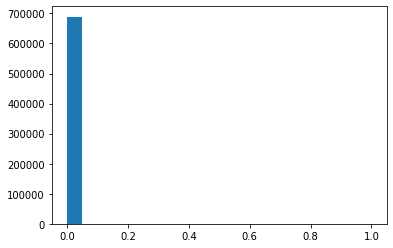

In [95]:
_ = plt.hist(music_note_sorted.values(), bins='auto')

In [96]:
collections.Counter(music_note_sorted.values())

Counter({1: 18, 0: 688963})

In [90]:
to_print = []
for music in music_note_sorted:
    if music_note_sorted[music] == 1:
        to_print.append(music)

print(','.join(to_print))

spotify:track:5eAZSmWJjKNnMposeGbcCh,spotify:track:41OAXzXCrDCzRSlD1IBWtP,spotify:track:2wbkovH4lLaiaFOceX1YAr,spotify:track:6mEpGxnTjoMdZQjo6UorbK,spotify:track:70kJ2O6JiFg4nTATPw4b0E,spotify:track:3wsZYuHJrk3lssa7V7jvye,spotify:track:49eFn8tzVzaJdfmzlSny1S,spotify:track:6DzvC1VHpyTFfLBbAYBa7W,spotify:track:1AfMZzTtm4rDQNWqWKfCxC,spotify:track:4LoMqgfxEbYZrnqxloUMAq,spotify:track:4DNyKoJBdTpLnA3ryWL7Qh,spotify:track:0byuRCilUoNe3rKG8VKCx8,spotify:track:5xCTuWjQpUxLNeQ0XmtsCo,spotify:track:0vL6Dt7L7k9srca6XxtjBM,spotify:track:2exUyljlhoH86MlcicuUXd,spotify:track:1g0xyCMUBKUaMDCk00Hhmk,spotify:track:76PS07wzG7zYMy8rHPjL2t,spotify:track:14WxdK01IyDl3bumvqufxH


# Top 15 negativas

In [97]:
not_music = {}
for item in music_note_sorted:
    if music_note_sorted[item] == 0:
        not_music[item] = music_popularity[item]

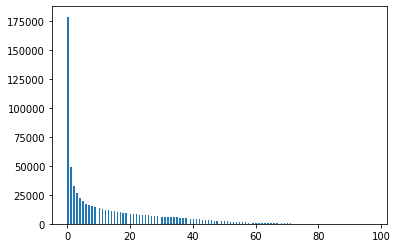

In [99]:
_ = plt.hist(not_music.values(), bins='auto')

In [100]:
not_music_note_sorted = dict(sorted(not_music.items(), key=lambda item: item[1], reverse=True)) 

In [104]:
to_print = list(not_music_note_sorted.keys())[0:15]
print(','.join(to_print)) 

spotify:track:748mdHapucXQri7IAO8yFK,spotify:track:2JPLbjOn0wPCngEot2STUS,spotify:track:5CZ40GBx1sQ9agT82CLQCT,spotify:track:6HU7h9RYOaPRFeh0R3UeAr,spotify:track:6hf0RpxTbOprT5nnwzkk8e,spotify:track:6PQ88X9TkUIAUIZJHW2upE,spotify:track:4pt5fDVTg5GhEvEtlz9dKk,spotify:track:2tGvwE8GcFKwNdAXMnlbfl,spotify:track:7MAibcTli4IisCtbHKrGMh,spotify:track:5JCoSi02qi3jJeHdZXMmR8,spotify:track:5wANPM4fQCJwkGd4rN57mH,spotify:track:05bfbizlM5AX6Mf1RRyMho,spotify:track:6SRsiMl7w1USE4mFqrOhHC,spotify:track:0MMyJUC3WNnFS1lit5pTjk,spotify:track:2dNhNlpZAtV4lwAFW45LIv
